# Likelihood Analysis with Python

The python likelihood tools are a very powerful set of analysis tools that expand upon the command line tools provided with the Fermitools package.

Not only can you perform all of the same likelihood analysis with the python tools that you can with the standard command line tools, but you can directly access all of the model parameters.

You can more easily script a standard analysis like light curve generation. There are also a few things built into the python tools that are not available from the command line like the calculation of upper limits.


***

This sample analysis is based on the PG 1553+113 analysis performed by the LAT team and described in [Abdo, A. A. et al. 2010, ApJ, 708, 1310](http://adsabs.harvard.edu/abs/2010ApJ...708.1310A).


After you complete this tutorial, you should be able to reproduce all of the data analysis performed in this publication including generating a spectrum (individual bins and a butterfly plot) and produce a light curve with the python tools.

This tutorial assumes you have the most recent [Fermitools](https://fermi.gsfc.nasa.gov/ssc/data/analysis/software/) installed.

We will also make significant use of python, so you might want to familiarize yourself with python (there's a beginner's guide at http://wiki.python.org/moin/BeginnersGuide). This tutorial also assumes that you've gone through the non-python based unbinned likelihood thread. This tutorial should take approximately 8 hours to complete (depending on your computer's speed) if you do everything, but there are some steps you can skip along the way which shave about 4 hours off of that.

# Get the data

For this thread the original data were extracted from the [LAT data server](https://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/LATDataQuery.cgi) with the following selections (these selections are similar to those in the paper):

```
Search Center (RA,Dec) = (238.929,11.1901)
Radius = 20 degrees
Start Time (MET) = 239557417 seconds (2008-08-04T15:43:37)
Stop Time (MET) = 256970880 seconds (2009-02-22T04:48:00)
Minimum Energy = 100 MeV
Maximum Energy = 300000 MeV
```



These are the event files. Run the code cell below to retrieve them:
```
L1504241622054B65347F25_PH00.fits
L1504241622054B65347F25_PH01.fits
L1504241622054B65347F25_SC00.fits
```

In [1]:
!wget https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/pyLikelihood/L1504241622054B65347F25_PH00.fits
!wget https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/pyLikelihood/L1504241622054B65347F25_PH01.fits
!wget https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/pyLikelihood/L1504241622054B65347F25_SC00.fits

--2025-12-08 15:13:04--  https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/pyLikelihood/L1504241622054B65347F25_PH00.fits
Resolving fermi.gsfc.nasa.gov (fermi.gsfc.nasa.gov)... 129.164.179.26
Connecting to fermi.gsfc.nasa.gov (fermi.gsfc.nasa.gov)|129.164.179.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11160000 (11M) [application/fits]
Saving to: ‘L1504241622054B65347F25_PH00.fits’

L1504241622054B6534 100%[===================>]  10.64M  1.33MB/s    in 7.8s    

2025-12-08 15:13:12 (1.36 MB/s) - ‘L1504241622054B65347F25_PH00.fits’ saved [11160000/11160000]

--2025-12-08 15:13:12--  https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/pyLikelihood/L1504241622054B65347F25_PH01.fits
Resolving fermi.gsfc.nasa.gov (fermi.gsfc.nasa.gov)... 129.164.179.26
Connecting to fermi.gsfc.nasa.gov (fermi.gsfc.nasa.gov)|129.164.179.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14685120 (14M) [application/fits]
Saving to: ‘

In [2]:
!mkdir data
!mv *SC00.fits PG1553_SC.fits
!mv *.fits ./data

mkdir: data: File exists


You'll first need to make a file list with the names of your input event files.

In [3]:
!ls ./data/*PH*.fits > ./data/PG1553_events.list
!cat ./data/PG1553_events.list

./data/L1504241622054B65347F25_PH00.fits
./data/L1504241622054B65347F25_PH01.fits


In the following analysis, we've assumed that you've named your list of data files `PG1553_events.list` and the spacecraft file `PG1553_SC.fits`.

# Perform Event Selections

You could follow the unbinned likelihood tutorial to perform your event selections using **gtlike*, **gtmktime**, etc. directly from the command line, and then use pylikelihood later.

But we're going to go ahead and use python. The `gt_apps` module provides methods to call these tools from within python. This'll get us used to using python.

So, let's jump into python:

In [4]:
import gt_apps as my_apps

Now, you can see what objects are part of the gt_apps module by executing:

In [5]:
help(my_apps)

Help on module gt_apps:

NAME
    gt_apps - This module uses GtApp to wraps the Science Tools as python objects.

DATA
    TsMap = <GtApp.GtApp object>
    addCubes = <GtApp.GtApp object>
    counts_map = <GtApp.GtApp object>
    diffResps = <GtApp.GtApp object>
    evtbin = <GtApp.GtApp object>
    expCube = <GtApp.GtApp object>
    expMap = <GtApp.GtApp object>
    filter = <GtApp.GtApp object>
    gtexpcube2 = <GtApp.GtApp object>
    like = <GtApp.GtApp object>
    maketime = <GtApp.GtApp object>
    model_map = <GtApp.GtApp object>
    rspgen = <GtApp.GtApp object>
    srcMaps = <GtApp.GtApp object>

FILE
    /Users/nmirabal/miniconda3/envs/fermi-2.4.157/lib/python3.11/site-packages/fermitools/gt_apps.py




The python object for **gtselect** is called `filter`, and we first need to set all of its options.

This is very similar to calling **gtselect** from the command line and inputting all of the variables interactively. 

For example, towards the end of this thread, we'll want to generate a light curve and we'll have to run the likelihood analysis for each datapoint. It'll be much easier to do all of this within python and change the `tmin` and `tmax` in an iterative fashion.

Note that these python objects are just wrappers for the standalone tools, so if you want any information on their options, see the corresponding [documentation](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/references.html) for the standalone tool.

Let's set **gtselect**'s (or `filter`'s) options:

In [6]:
my_apps.filter['evclass'] = 128
my_apps.filter['evtype'] = 3
my_apps.filter['ra'] = 238.929
my_apps.filter['dec'] = 11.1901
my_apps.filter['rad'] = 10
my_apps.filter['emin'] = 100
my_apps.filter['emax'] = 300000
my_apps.filter['zmax'] = 90
my_apps.filter['tmin'] = 239557417
my_apps.filter['tmax'] = 256970880
my_apps.filter['infile'] = '@./data/PG1553_events.list'
my_apps.filter['outfile'] = './data/PG1553_filtered.fits'

And now we run **gtselect**:

In [7]:
my_apps.filter.run()

time -p gtselect infile=@./data/PG1553_events.list outfile=./data/PG1553_filtered.fits ra=238.929 dec=11.1901 rad=10.0 tmin=239557417.0 tmax=256970880.0 emin=100.0 emax=300000.0 zmin=0.0 zmax=90.0 evclass=128 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
Done.
real 0.75
user 0.57
sys 0.05


Note that you can see exactly what gtselect will do if you run it by typing

In [8]:
my_apps.filter.command()

'time -p gtselect infile=@./data/PG1553_events.list outfile=./data/PG1553_filtered.fits ra=238.929 dec=11.1901 rad=10.0 tmin=239557417.0 tmax=256970880.0 emin=100.0 emax=300000.0 zmin=0.0 zmax=90.0 evclass=128 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"'

You have access to any of the inputs by directly accessing the `filter['OPTIONS']` options.

Next, you need to run **gtmktime**. This is accessed within python via the `maketime` object:

In [9]:
my_apps.maketime['scfile'] = './data/PG1553_SC.fits'
my_apps.maketime['filter'] = '(DATA_QUAL>0)&&(LAT_CONFIG==1)'
my_apps.maketime['roicut'] = 'no'
my_apps.maketime['evfile'] = './data/PG1553_filtered.fits'
my_apps.maketime['outfile'] = './data/PG1553_filtered_gti.fits'

In [10]:
my_apps.maketime.run()

time -p gtmktime scfile=./data/PG1553_SC.fits sctable="SC_DATA" filter="(DATA_QUAL>0)&&(LAT_CONFIG==1)" roicut=no evfile=./data/PG1553_filtered.fits evtable="EVENTS" outfile="./data/PG1553_filtered_gti.fits" apply_filter=yes overwrite=no header_obstimes=yes tstart=0.0 tstop=0.0 gtifile="default" chatter=2 clobber=yes debug=no gui=no mode="ql"
real 1.21
user 1.05
sys 0.08


We're using the most conservative and most commonly used cuts described in detail [here](https://fermi.gsfc.nasa.gov/ssc/data/analysis/likelihood/lat_exposure.html).

# Livetime Cubes and Exposure Maps

At this point, you could make a counts map of the events we just selected using [gtbin](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/help/gtbin.txt) (it's called `evtbin` within python) and I won't discourage you, but we're going to go ahead and create a livetime cube and exposure map.

This might take a few minutes to complete, so if you want to create a counts map and have a look at it, get these processes going and open another terminal to work on your counts map (see the [likelihood tutorial](https://github.com/fermi-lat/AnalysisThreads/blob/master/SourceAnalysis/2.UnbinnedLikelihood/likelihood_tutorial.ipynb) for an example of running **gtbin** to produce a counts map).

### Livetime Cube

This step will take approximately 15 - 30 minutes to complete so if you want to just download the `PG1553_ltCube.fits` from us you can skip this step by running the code cell below.

In [11]:
!wget http://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/pyLikelihood/PG1553_ltCube.fits
!mv *.fits ./data

URL transformed to HTTPS due to an HSTS policy
--2025-12-08 15:14:24--  https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/pyLikelihood/PG1553_ltCube.fits
Resolving fermi.gsfc.nasa.gov (fermi.gsfc.nasa.gov)... 129.164.179.26
Connecting to fermi.gsfc.nasa.gov (fermi.gsfc.nasa.gov)|129.164.179.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16597440 (16M) [application/fits]
Saving to: ‘PG1553_ltCube.fits’

PG1553_ltCube.fits  100%[===================>]  15.83M  1.54MB/s    in 12s     

2025-12-08 15:14:37 (1.28 MB/s) - ‘PG1553_ltCube.fits’ saved [16597440/16597440]



If instead you wish to do this yourself, **gtltcube** is `expCube` and you set its options like so:

In [12]:
my_apps.expCube['evfile'] = './data/PG1553_filtered_gti.fits'
my_apps.expCube['scfile'] = './data/PG1553_SC.fits'
my_apps.expCube['outfile'] = './data/PG1553_ltCube.fits'
my_apps.expCube['zmax'] = 90
my_apps.expCube['dcostheta'] = 0.025
my_apps.expCube['binsz'] = 1

In [13]:
my_apps.expCube.run()

time -p gtltcube evfile="./data/PG1553_filtered_gti.fits" evtable="EVENTS" scfile=./data/PG1553_SC.fits sctable="SC_DATA" outfile=./data/PG1553_ltCube.fits dcostheta=0.025 binsz=1.0 phibins=0 tmin=0.0 tmax=0.0 file_version="1" zmin=0.0 zmax=90.0 chatter=2 clobber=yes debug=no gui=no mode="ql"
Working on file ./data/PG1553_SC.fits
.....................!
real 318.38
user 317.17
sys 0.64


While you're waiting, you might have noticed that not all of the command line Fermitools have an equivalent object in `gt_apps`.

This is easy to fix. Say you want to use **gtltcubesun** from within python. Just make it a GtApp:

In [14]:
from GtApp import GtApp
expCubeSun = GtApp('gtltcubesun','Likelihood')
expCubeSun.command()

'time -p gtltcubesun evfile="./3C279_binned_gti.fits" evtable="EVENTS" scfile=./L181126210218F4F0ED2738_SC00.fits sctable="SC_DATA" outfile=./3C279_binned_ltcube_moon_01.fits body="MOON" dcostheta=0.025 thetasunmax=1.0 binsz=0.5 phibins=0 tmin=0.0 tmax=0.0 powerbinsun=2.7 file_version="1" zmax=180.0 chatter=2 clobber=yes debug=no gui=no mode="ql"'

### Exposure Map

Similar to Livetime Cube above.

In [15]:
my_apps.expMap['evfile'] = './data/PG1553_filtered_gti.fits'
my_apps.expMap['scfile'] = './data/PG1553_SC.fits'
my_apps.expMap['expcube'] = './data/PG1553_ltCube.fits'
my_apps.expMap['outfile'] = './data/PG1553_expMap.fits'
my_apps.expMap['irfs'] = 'CALDB'
my_apps.expMap['srcrad'] = 20
my_apps.expMap['nlong'] = 120
my_apps.expMap['nlat'] = 120
my_apps.expMap['nenergies'] = 37

In [16]:
my_apps.expMap.run()

time -p gtexpmap evfile=./data/PG1553_filtered_gti.fits evtable="EVENTS" scfile=./data/PG1553_SC.fits sctable="SC_DATA" expcube=./data/PG1553_ltCube.fits outfile=./data/PG1553_expMap.fits irfs="CALDB" evtype="INDEF" srcrad=20.0 nlong=120 nlat=120 nenergies=37 submap=no nlongmin=0 nlongmax=0 nlatmin=0 nlatmax=0 chatter=2 clobber=yes debug=no gui=no mode="ql"
The exposure maps generated by this tool are meant
to be used for *unbinned* likelihood analysis only.
Do not use them for binned analyses.
real 310.91
user 305.26
sys 5.46


# Generate XML Model File

We need to create an XML file with all of the sources of interest within the Region of Interest (ROI) of PG 1553+113 so we can correctly model the background. For more information on the format of the model file and how to create one, see the [likelihood analysis](https://github.com/fermi-lat/AnalysisThreads/blob/master/SourceAnalysis/2.UnbinnedLikelihood/likelihood_tutorial.ipynb) tutorial.

For this thread, we use a simplified model with just two sources: [PG1553compact_model.xml](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/pyLikelihood/PG1553compact_model.xml).

To fit all 4FGL-DR4 sources, you can use the user contributed [LATSourceModel](https://github.com/physicsranger/make4FGLxml) package to create a model file based on the LAT 14-year LAT catalog. You'll need to download the XML or FITS version of this file at http://fermi.gsfc.nasa.gov/ssc/data/access/lat/14yr_catalog/ and put it in your working directory. You will also need to install the [LATSourceModel](https://github.com/physicsranger/make4FGLxml) package (see also [this page](https://fermi.gsfc.nasa.gov/ssc/data/analysis/user/)). Also make sure you have the most recent galactic diffuse and isotropic model files which can be found at [here](http://fermi.gsfc.nasa.gov/ssc/data/access/lat/BackgroundModels.html). The catalog and background models are packaged with your installation of the Fermitools, which can be found at $FERMI_DIR//refdata/fermi/galdiffuse/.

The catalog and background models are also packaged with your installation of the Fermitools, which can be found at: `$FERMI_DIR//refdata/fermi/galdiffuse/`.

In [17]:
!wget https://fermi.gsfc.nasa.gov/ssc/data/access/lat/14yr_catalog/gll_psc_v32.xml
!wget https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/pyLikelihood/PG1553compact_model.xml

--2025-12-08 15:25:07--  https://fermi.gsfc.nasa.gov/ssc/data/access/lat/14yr_catalog/gll_psc_v32.xml
Resolving fermi.gsfc.nasa.gov (fermi.gsfc.nasa.gov)... 129.164.179.26
Connecting to fermi.gsfc.nasa.gov (fermi.gsfc.nasa.gov)|129.164.179.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12719321 (12M) [application/xml]
Saving to: ‘gll_psc_v32.xml’

gll_psc_v32.xml     100%[===================>]  12.13M  2.13MB/s    in 8.1s    

2025-12-08 15:25:15 (1.50 MB/s) - ‘gll_psc_v32.xml’ saved [12719321/12719321]

--2025-12-08 15:25:15--  https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/data/pyLikelihood/PG1553compact_model.xml
Resolving fermi.gsfc.nasa.gov (fermi.gsfc.nasa.gov)... 129.164.179.26
Connecting to fermi.gsfc.nasa.gov (fermi.gsfc.nasa.gov)|129.164.179.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2745 (2.7K) [application/xml]
Saving to: ‘PG1553compact_model.xml’

PG1553compact_model 100%[===================>]   2.68K 

In [18]:
!mv *.xml ./data

In [19]:
!pip install LATSourceModel

Once you have all of the files, you can generate your model file in python:

In [20]:
from LATSourceModel import SourceList

source_list = SourceList(catalog_file='./data/gll_psc_v32.xml',
                         ROI='./data/PG1553_filtered_gti.fits',
                         output_name='./data/PG1553_model.xml',
                         DR=4)
source_list.make_model()

/Users/nmirabal/miniconda3/envs/fermi-2.4.157/lib/python3.11/site-packages/LATSourceModel/SourceList.py:154: UserWarning: Region XML model data/PG1553_model.xml already exists, will be overwritten if you call the make_model method.
  warnings.warn(f'Region XML model {str(self.output_name)} already exists, will be\


Creating spatial and spectral model from the 4FGL DR-4 catalog: data/gll_psc_v32.xml.
Added 164 point sources and 0 extended sources.
Building ds9-style region file...done!
File saved as data/ROI_PG1553_model.reg.


In the paper, the LAT team only included two sources: one from the `0FGL` catalog and another non-catalog source. This is because the later LAT catalogs had not been released at the time. For a more updated model, one should use the latest 4FGL information.

Back to looking at our compact XML model file: notice that PG 1553+113 is listed in the model file as 4FGL J1555.7+1111 with all of the parameters filled in for us.

It's actually offset from the center of our ROI by 0.003 degrees.

How nice!

Also notice that we changed the model for 4FGL J1555.7+1111 from a Log Parabola to a simple power-law for the purposes of this analysis thread.

# Compute the diffuse source responses

The diffuse source responses tell the likelihood fitter what the expected contribution would be for each diffuse source, given the livetime associated with each event.

The source model XML file must contain all of the diffuse sources to be fit. The [gtdiffrsp](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/help/gtdiffrsp.txt) tool will add one column to the event data file for each diffuse source.

The diffuse response depends on the instrument response function (IRF), which must be in agreement with the selection of events, i.e. the event class and event type we are using in our analysis. Since we are using SOURCE class, `CALDB` should use the `P8R3_SOURCE_V3` IRF for this tool.

If the diffuse responses are not precomputed using [gtdiffrsp](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/help/gtdiffrsp.txt), then the [gtlike](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/help/gtlike.txt) tool will compute them at runtime (during the next step).

However, as this step is very computationally intensive (often taking ~hours to complete), and it is very likely you will need to run [gtlike](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/help/gtlike.txt) more than once, it is probably wise to precompute these quantities.

In [21]:
my_apps.diffResps['evfile'] = './data/PG1553_filtered_gti.fits'
my_apps.diffResps['scfile'] = './data/PG1553_SC.fits'
my_apps.diffResps['srcmdl'] = './data/PG1553compact_model.xml'
my_apps.diffResps['irfs'] = 'CALDB'
my_apps.diffResps.run()

time -p gtdiffrsp evfile=./data/PG1553_filtered_gti.fits evtable="EVENTS" scfile=./data/PG1553_SC.fits sctable="SC_DATA" srcmdl=./data/PG1553compact_model.xml irfs="CALDB" evclsmin=0 evclass="INDEF" evtype="INDEF" convert=no chatter=2 clobber=no debug=no gui=no mode="ql"
adding source gll_iem_v07
adding source iso_P8R3_SOURCE_V3_v1
Working on...
./data/PG1553_filtered_gti.fits.....................!
real 1116.26
user 1110.39
sys 2.16


# Run the Likelihood Analysis

It's time to actually run the likelihood analysis now.

First, you need to import the pyLikelihood module and then the UnbinnedAnalysis functions (there's also a binned analysis module that you can import to do [binned likelihood analysis](https://github.com/fermi-lat/AnalysisThreads/blob/master/SourceAnalysis/1.BinnedLikelihood/binned_likelihood_tutorial.ipynb) which behaves almost exactly the same as the unbinned analysis module).

For more details on the pyLikelihood module, check out the [pyLikelihood Usage Notes](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/python_usage_notes.html).

In [22]:
import pyLikelihood
from UnbinnedAnalysis import *

obs = UnbinnedObs('./data/PG1553_filtered_gti.fits','./data/PG1553_SC.fits',expMap='./data/PG1553_expMap.fits', expCube='./data/PG1553_ltCube.fits',irfs='CALDB')
like = UnbinnedAnalysis(obs,'./data/PG1553compact_model.xml',optimizer='NewMinuit')

By now, you'll have two objects: `obs`, an UnbinnedObs object, and `like`, an UnbinnedAnalysis object.

You can view these objects attributes and set them from the command line in various ways. For example:

In [23]:
print(obs)

Event file(s): ./data/PG1553_filtered_gti.fits
Spacecraft file(s): ./data/PG1553_SC.fits
Exposure map: ./data/PG1553_expMap.fits
Exposure cube: ./data/PG1553_ltCube.fits
IRFs: CALDB


In [24]:
print(like)

Event file(s): ./data/PG1553_filtered_gti.fits
Spacecraft file(s): ./data/PG1553_SC.fits
Exposure map: ./data/PG1553_expMap.fits
Exposure cube: ./data/PG1553_ltCube.fits
IRFs: CALDB
Source model file: ./data/PG1553compact_model.xml
Optimizer: NewMinuit


or you can get directly at the objects attributes and methods by:

In [25]:
dir(like)

['NpredValue',
 'Ts',
 'Ts_old',
 '_Nobs',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_errors',
 '_importPlotter',
 '_inputs',
 '_isDiffuseOrNearby',
 '_minosIndexError',
 '_npredValues',
 '_plotData',
 '_plotResiduals',
 '_plotSource',
 '_renorm',
 '_separation',
 '_setSourceAttributes',
 '_srcCnts',
 '_srcDialog',
 '_xrange',
 'addGaussianPrior',
 'addPrior',
 'addPriors',
 'addSource',
 'constrain_norms',
 'constrain_params',
 'covar_is_current',
 'covariance',
 'deleteSource',
 'disp',
 'e_vals',
 'energies',
 'energyFlux',
 'energyFluxError',
 'fit',
 'flux',
 'fluxError',
 'freePars',
 'freeze',


or get even more details by executing:

In [26]:
help(like)

Help on UnbinnedAnalysis in module UnbinnedAnalysis object:

class UnbinnedAnalysis(AnalysisBase.AnalysisBase)
 |  UnbinnedAnalysis(observation, srcModel=None, optimizer='Drmngb', nee=21)
 |  
 |  Method resolution order:
 |      UnbinnedAnalysis
 |      AnalysisBase.AnalysisBase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, observation, srcModel=None, optimizer='Drmngb', nee=21)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  plotSourceFit(self, srcName, color='black')
 |  
 |  reset_ebounds(self, new_energies)
 |  
 |  setEnergyRange(self, emin, emax)
 |  
 |  state(self, output=<ipykernel.iostream.OutStream object at 0x111e2de70>)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from AnalysisBase.AnalysisBase:
 |  
 |  NpredValue(self, src, weighted=False)
 |      Returns the number of predicted counts for a source.
 |  
 |  Ts(self, srcName, reoptimize=False, approx

There are a lot of attributes, and here you start to see the power of using pyLikelihood since you'll be able to (once the fit is done) access any of these attributes directly within python and use them in your own scripts.

For example: you can see that the like object has a `tol` attribute, which we can read back to see what it is and, then set it to what we want it to be.

In [27]:
like.tol
like.tolType
like.tol = 0.0001

Now, we're ready to do the actual fit.

This next step can take anywhere from 10 minutes to a few hours to complete depending on your system.

We're doing something a bit fancy here. We're getting the minimizating object (and calling it `likeobj`) from the `logLike` object so that we can access it later.

We pass this object to the fit routine so that it knows which fitting object to use. We're also telling the code to calculate the covariance matrix so we can get at the errors.

In [28]:
likeobj = pyLike.NewMinuit(like.logLike)
like.fit(verbosity=0,covar=True,optObject=likeobj)

569867.6199595158

The number that is printed out here is the -log(Likelihood) of the total fit to the data.

You can print the results of the fit by accessing `like.model`. You can now plot the results of the fit by executing the `plot` command. The results are shown below:

Data  53445.0
srcName  1456.5653740618136
srcName  1182.0480770925597
srcName  27730.229289845145
srcName  23110.001958634613
Resid  53445.0 53478.84469963414 -0.7244427503329167


/Users/nmirabal/miniconda3/envs/fermi-2.4.157/lib/python3.11/site-packages/fermitools/MPLPlot.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()
/Users/nmirabal/miniconda3/envs/fermi-2.4.157/lib/python3.11/site-packages/fermitools/MPLPlot.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


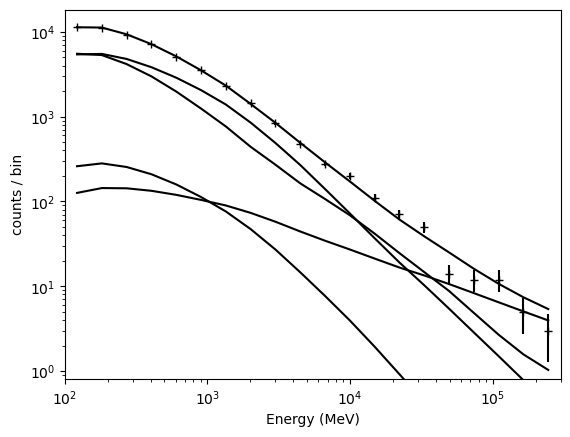

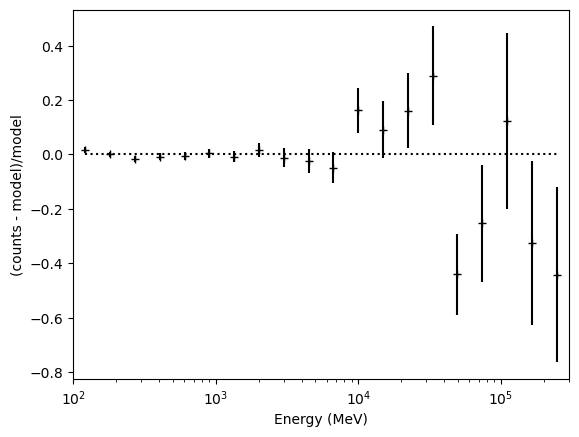

In [29]:
%matplotlib inline
like.plot()

The output of the plot function of the like1 UnbinnedAnalysis object shows:

* Left: the contribution of each of the objects in the model to the total model, and plots the data points on top.

* Right: the residuals of the likelihood fit to the data. Notice that the fit is poor in the second to last bin.

Now, check if `NewMinuit` converged.

In [30]:
print(likeobj.getRetCode())

0


If you get anything other than '0' here, then NewMinuit didn't converge. There are several reasons that we might not get convergence:

* The culprit is usually a parameter (or parameters) in the model that reach the limits set in the XML file. If this happens, the minimizer cannot reach the formal minimum and hence cannot calculate the curvature.


* Often the problem is with spectral shape parameters (PL index, etc.), so simply freezing the shape of all spectral parameters to their values from the full time period (and certainly for weaker background sources) when fitting a shorter time period may solve the problem. Remember that the 4FGL catalog used a full 8 years of data and we're using a much shorter time period here.


* Weak background sources are more likely to cause problems, so you could consider just freezing them completely (or removing them from the model).

    For example: a background source from the catalog that is detected at TS~=25 in 2 years could cause convergence problems in a 1-month light curve, where it will often not be detectable at all.


* If there are no parameters at their limits, then increasing the overall convergence tolerance may help - try using a value of 1E-8 for the absolute tolerance.


* If that doesn't help, then try to systematically simplify the model. Progressively freeze all sources, starting with those at the edge of the ROI in and moving in until you get a model simple enough for the minimizer to work reliably.

    For example: if you are using a 10 degree ROI, you could start by freezing all background sources further than 7 degrees from the source of interest, and move to 5 degrees if that doesn't solve the problem.

In our case, we have convergence, and we can move forward.

Note, however, that this doesn't mean you have the 'right' answer. It just means that you have the answer assuming the model you put in. This is a subtle feature of the likelihood method.

Let's take a look at the residuals and overall model using `matplotlib`.

In [31]:
import matplotlib.pyplot as plt
import numpy as np

We need to import these two modules for plotting and some other stuff. They are included in the Fermitools.

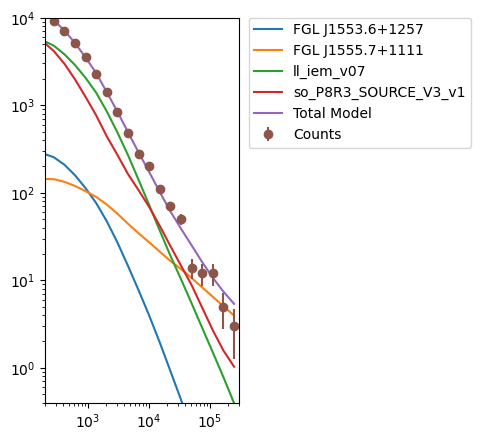

In [32]:
E = (like.energies[:-1] + like.energies[1:])/2.
# The 'energies' array are the endpoints so we take
# the midpoint of the bins.

plt.figure(figsize=(5,5))
plt.ylim((0.4,1e4))
plt.xlim((200,300000))
sum_model = np.zeros_like(like._srcCnts(like.sourceNames()[0]))

for sourceName in like.sourceNames():
    sum_model = sum_model + like._srcCnts(sourceName)
    plt.loglog(E,like._srcCnts(sourceName),label=sourceName[1:])

plt.loglog(E,sum_model,label='Total Model')
plt.errorbar(E,like._Nobs(),yerr=np.sqrt(like._Nobs()), fmt='o',label='Counts')
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

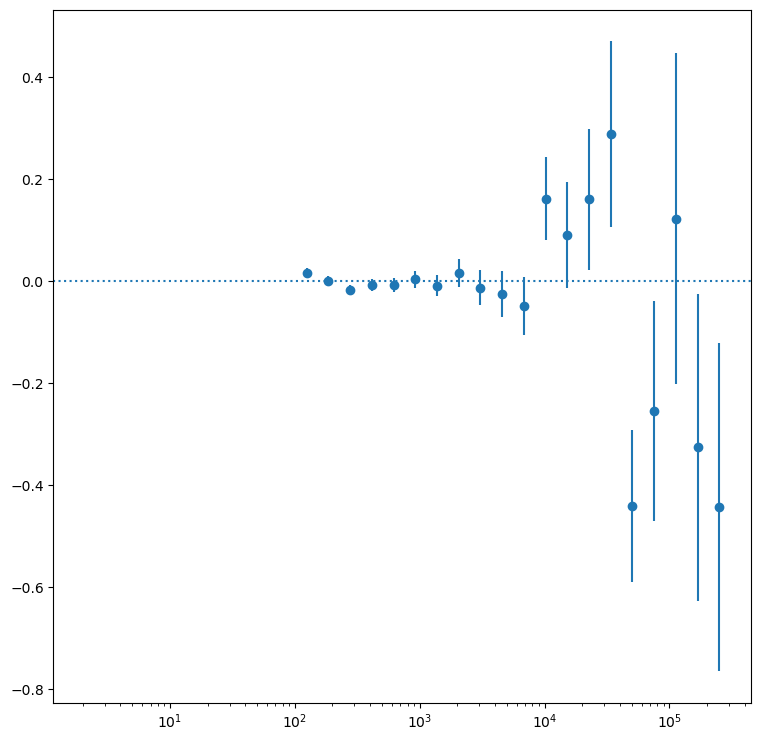

In [33]:
resid = (like._Nobs() - sum_model)/sum_model
resid_err = (np.sqrt(like._Nobs())/sum_model)
plt.figure(figsize=(9,9))
plt.xscale('log')
plt.errorbar(E,resid,yerr=resid_err,fmt='o')
plt.axhline(0.0,ls=':')
plt.show()

These are just some examples of how to access the underlying data from the python tools.

As you can see, most of the information is accessable if you dig around. Note that the residuals aren't that great in several bins especially at high energies.

This could be a missing source or that we're not modelling a bright source very well. If you look up at the model plot, the high energy tail of PG1553 might be biasing the fit at high energies and we might get a better fit with a log-parabola or broken power-law. That's for another day, though.

Let's check out the final parameters of the fit for PG1553.

In [34]:
like.model['4FGL J1555.7+1111']

4FGL J1555.7+1111
   Spectrum: PowerLaw
4      Prefactor:  3.053e+00  1.991e-01  1.000e-04  1.000e+04 ( 1.000e-11)
5          Index:  1.608e+00  2.881e-02  0.000e+00  1.000e+01 (-1.000e+00)
6          Scale:  5.000e+02  0.000e+00  3.000e+01  5.000e+05 ( 1.000e+00) fixed

In [35]:
like.flux('4FGL J1555.7+1111',emin=100)

6.629863921426104e-08

In [36]:
like.fluxError('4FGL J1555.7+1111',emin=100)

4.361271109055268e-09

You can also get the TS value for a specific source:

In [37]:
like.Ts('4FGL J1555.7+1111')

2843.84852510388

You can calculate how many standard deviations (σ) this corresponds to.

Remember that the [TS value is ∼ $σ^2$](https://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_Likelihood/Likelihood_overview.html).

In [38]:
np.sqrt(like.Ts('4FGL J1555.7+1111'))

53.32774629687514

Save the results:

In [39]:
like.logLike.writeXml('PG1553_fit.xml')

In [40]:
!mv *.xml ./data

# Create some TS Maps

If you want to check on your fit, you should probably make a test statistic (TS) map of your region at this point.

This will allow you to check and make sure that you didn't miss anything in the ROI (like a source not in the catalog you used).

A TS map is created by moving a putative point source through a grid of locations on the sky and maximizing the log(likelihood) at each grid point.

We're going to make two TS Maps. If you have access to multiple CPUs, you might want to start one of the maps running in one terminal and the other in another one since this will take **several hours** to complete.

Our main goal is to create one TS Map with PG1553 included in the fit and another without. The first one will allow us to make sure we didn't miss any sources in our ROI and the other will allow us to see the source.

All of the other sources in our model file will be included in the fit and shouldn't show up in the final map.

If you don't want to create these maps, go ahead and skip the following steps and jump to the section on making a butterfly plot. The creation of these maps is optional and is only for double checking your work.

You should still modify your model fit file as detailed in the following:

Copy `PG1553_fit.xml` as `PG1553_fit_TSMap.xml`. Modify `PG1553_fit_TSMap.xml` to make everything fixed by changing all of the `free="1"` statements to `free="0"`. Modify the lines that look like:

```xml
<parameter error="1.670710816" free="1" max="10000" min="0.0001" name="Prefactor" scale="1e-13" value="6.248416874" />
<parameter error="0.208035277" free="1" max="5" min="0" name="Index" scale="-1" value="2.174167564" />
```

to look like:

```xml
<parameter error="1.670710816" free="0" max="10000" min="0.0001" name="Prefactor" scale="1e-13" value="6.248416874" />
<parameter error="0.208035277" free="0" max="5" min="0" name="Index" scale="-1" value="2.174167564" />
```

In [41]:
!cp ./data/PG1553_fit.xml ./data/PG1553_fit_TSMap.xml

In [42]:
with open("./data/PG1553_fit_TSMap.xml") as file:
    file.read().replace("free=0", "free=1")

Then copy it and call it `PG1553_fit_noPG1553.xml` and comment out (or delete) the PG1553 source.

In [43]:
!cp ./data/PG1553_fit_TSMap.xml ./data/PG1553_fit_noPG1553.xml

 If you want to generate the TS maps, in one window do the following:

In [44]:
my_apps.TsMap['statistic'] = "UNBINNED"
my_apps.TsMap['scfile'] = "./data/PG1553_SC.fits"
my_apps.TsMap['evfile'] = "./data/PG1553_filtered_gti.fits"
my_apps.TsMap['expmap'] = "./data/PG1553_expMap.fits"
my_apps.TsMap['expcube'] = "./data/PG1553_ltCube.fits"
my_apps.TsMap['srcmdl'] = "./data/PG1553_fit_TSMap.xml"
my_apps.TsMap['irfs'] = "CALDB"
my_apps.TsMap['optimizer'] = "DRMNGB"
my_apps.TsMap['outfile'] = "./data/PG1553_TSmap_resid.fits"
my_apps.TsMap['nxpix'] = 10
my_apps.TsMap['nypix'] = 10
my_apps.TsMap['binsz'] = 0.5
my_apps.TsMap['coordsys'] = "CEL"
my_apps.TsMap['xref'] = 238.929
my_apps.TsMap['yref'] = 11.1901
my_apps.TsMap['proj'] = 'STG'
my_apps.TsMap.run()

time -p gttsmap irfs="CALDB" evtype="INDEF" expcube=./data/PG1553_ltCube.fits srcmdl=./data/PG1553_fit_TSMap.xml statistic="UNBINNED" optimizer="DRMNGB" ftol=0.001 toltype="ABS" evfile=./data/PG1553_filtered_gti.fits evtable="EVENTS" scfile=./data/PG1553_SC.fits sctable="SC_DATA" expmap=./data/PG1553_expMap.fits cmap=g28.8p0.5_filtered_ccube.fits bexpmap=g28.8p0.5_binned_expcube.fits wmap=none psfcorr=yes edisp_bins=0 outfile=./data/PG1553_TSmap_resid.fits nxpix=10 nypix=10 binsz=0.5 coordsys="CEL" xref=238.929 yref=11.1901 proj="STG" chatter=2 debug=no clobber=yes gui=no mode="ql"
....................!
real 1311.49
user 1302.32
sys 3.79


In another window, do the following:

In [45]:
my_apps.TsMap['statistic'] = "UNBINNED"
my_apps.TsMap['scfile'] = "./data/PG1553_SC.fits"
my_apps.TsMap['evfile'] = "./data/PG1553_filtered_gti.fits"
my_apps.TsMap['expmap'] = "./data/PG1553_expMap.fits"
my_apps.TsMap['expcube'] = "./data/PG1553_ltCube.fits"
my_apps.TsMap['srcmdl'] = "./data/PG1553_fit_noPG1553.xml"
my_apps.TsMap['irfs'] = "CALDB"
my_apps.TsMap['optimizer'] = "DRMNGB"
my_apps.TsMap['outfile'] = "./data/PG1553_TSmap_noPG1553.fits"
my_apps.TsMap['nxpix'] = 10
my_apps.TsMap['nypix'] = 10
my_apps.TsMap['binsz'] = 0.5
my_apps.TsMap['coordsys'] = "CEL"
my_apps.TsMap['xref'] = 238.929
my_apps.TsMap['yref'] = 11.1901
my_apps.TsMap['proj'] = 'STG'
my_apps.TsMap.run()

time -p gttsmap irfs="CALDB" evtype="INDEF" expcube=./data/PG1553_ltCube.fits srcmdl=./data/PG1553_fit_noPG1553.xml statistic="UNBINNED" optimizer="DRMNGB" ftol=0.001 toltype="ABS" evfile=./data/PG1553_filtered_gti.fits evtable="EVENTS" scfile=./data/PG1553_SC.fits sctable="SC_DATA" expmap=./data/PG1553_expMap.fits cmap=g28.8p0.5_filtered_ccube.fits bexpmap=g28.8p0.5_binned_expcube.fits wmap=none psfcorr=yes edisp_bins=0 outfile=./data/PG1553_TSmap_noPG1553.fits nxpix=10 nypix=10 binsz=0.5 coordsys="CEL" xref=238.929 yref=11.1901 proj="STG" chatter=2 debug=no clobber=yes gui=no mode="ql"
....................!
real 987.90
user 983.30
sys 1.98


This will take a while, so go get a cup of coffee.

The final TS maps will be pretty rough since we selected to only do 10x10 0.5 degree bins, but it will allow us to check if anything is missing and go back and fix it.

These rough plots aren't publication ready, but they'll do in a pinch to verify that we've got the model right.

Once the TS maps have been generated, open them up in whatever viewing program you wish.

Here's how you could use `matplotlib` to do it:

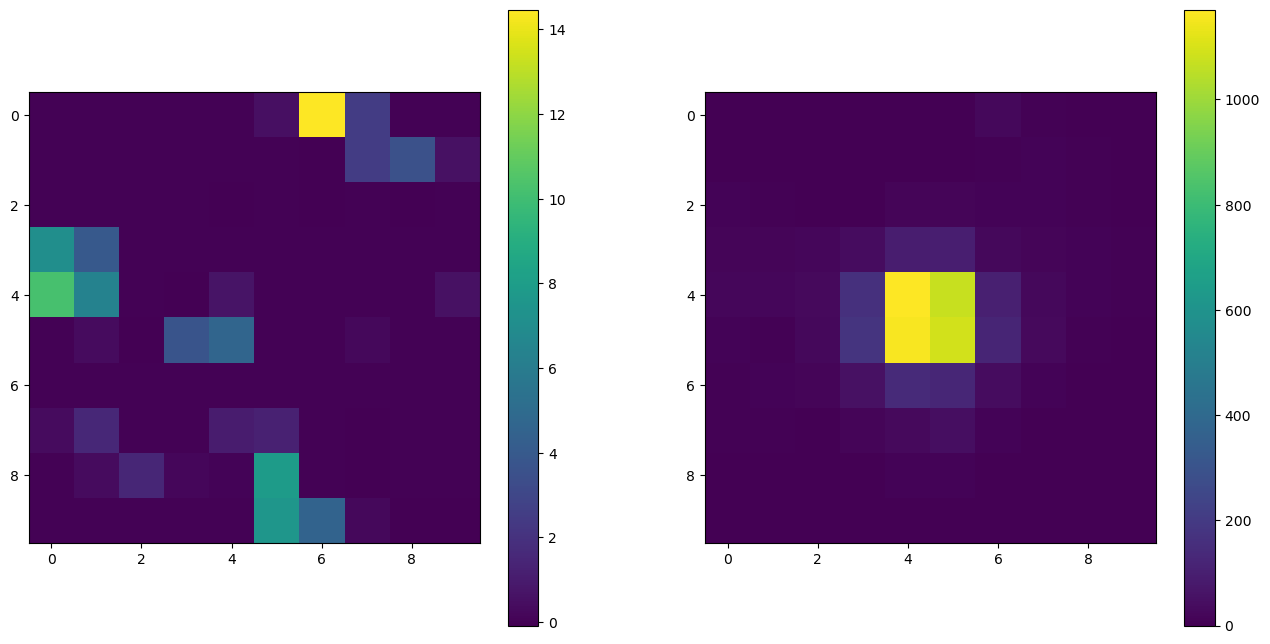

In [46]:
import astropy.io.fits as pyfits
residHDU = pyfits.open('./data/PG1553_TSmap_resid.fits')
sourceHDU = pyfits.open('./data/PG1553_TSmap_noPG1553.fits')
fig = plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(residHDU[0].data)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(sourceHDU[0].data)
plt.colorbar()
plt.show()

You can see that the `noPG1553` map (right) has a prominent source in the middle of the ROI.

This is PG 1553+113, and if you execute the following, you can see that the TS value of the maxiumum pretty well with the TS value of PG 1553+113 that we arrived at above.

In [47]:
np.max(sourceHDU[0].data)

1171.0537

If you then look at the `residuals` plot (left), you can see that it's pretty flat in TS space.

This indicates that we didn't miss any significant sources. If you did see something significant, you probably should go back and figure out what source you missed.

# Produce the Butterfly Plot

Now we'll produce the butterfly plot.

First, get the differential flux, the decorrelation (pivot) energy, and the index. You'll also need the errors.

In [48]:
N0 = like.model['4FGL J1555.7+1111'].funcs['Spectrum'].getParam('Prefactor').value()
N0_err = like.model['4FGL J1555.7+1111'].funcs['Spectrum'].getParam('Prefactor').error()
gamma = like.model['4FGL J1555.7+1111'].funcs['Spectrum'].getParam('Index').value()
gamma_err = like.model['4FGL J1555.7+1111'].funcs['Spectrum'].getParam('Index').error()
E0 = like.model['4FGL J1555.7+1111'].funcs['Spectrum'].getParam('Scale').value()

### Calculate the Butterfly Plot

We need to calculate the differential flux at several energy points as well as the error on that differential flux. The differential flux is defined as:

<img src='https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/images/pyLikelihood/PG1553_thread8x.png'>

and the error on that flux is defined as:

<img src='https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/images/pyLikelihood/PG1553_thread9x.png'>

Where cov<sub>γγ</sub> = σγ<sup>2</sup>, where γ is the spectral index. To calculate cov<sub>γγ</sub>, use this code:

In [49]:
freeParValues = []

for sourcename in like.sourceNames():
    for element in like.freePars(sourcename):
        freeParValues.append(element.getValue())

g_index = freeParValues.index(like.freePars('4FGL J1555.7+1111')[1].getValue())
cov_gg = like.covariance[g_index][g_index]

So, let calculate F(E) and F(E) +/- Δ F(E) so that we can plot it.

First, define a function for the flux and one for the error on the flux:

In [50]:
f = lambda E,N0,E0,gamma: N0*(E/E0)**(-1*gamma)
ferr = lambda E,F,N0,N0err,E0,cov_gg: F*np.sqrt(N0err**2/N0**2 + ((np.log(E/E0))**2)*cov_gg)

Now, generate some energies to evaluate the functions above and evaluate them.

In [51]:
E = np.logspace(2,5,100)
F = f(E,N0,E0,gamma)
Ferr = ferr(E,F,N0,N0_err,E0,cov_gg)

Now you can plot this. Here we're multiplying the flux by E<sup>2</sup> for clarity.

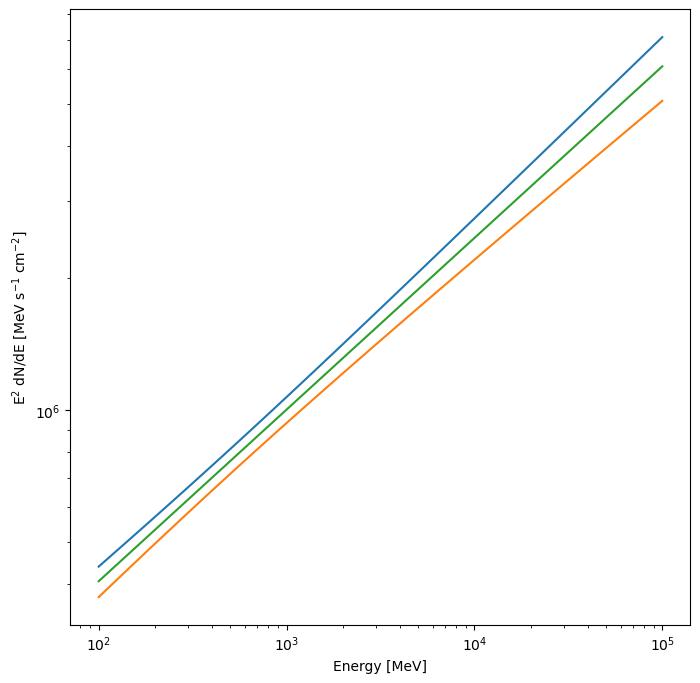

In [52]:
plt.figure(figsize=(8,8))
plt.xlabel('Energy [MeV]')
plt.ylabel(r'E$^2$ dN/dE [MeV s$^{-1}$ cm$^{-2}$]')
plt.loglog(E,E**2*(F+Ferr))
plt.loglog(E,E**2*(F-Ferr))
plt.plot(E,E**2*F)
plt.show()

The green line is the nominal fit, and the blue and orange lines are the 1 sigma contours.